In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
%matplotlib inline

In [3]:
df = pd.read_csv('data/train.csv')

In [4]:
from azureml.core import Workspace, Experiment

# Experiment name
exp_name = "titanic-lgbm"

# Configure experiment
ws = Workspace.from_config()
exp = Experiment(workspace=ws, name=exp_name)

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


In [5]:
df.drop(['PassengerId'], axis=1, inplace=True)

# 'Embarked' is stored as letters, so fit a label encoder to the train set to use in the loop
embarked_encoder = LabelEncoder()
embarked_encoder.fit(df['Embarked'].fillna('Null'))
 
# Record anyone travelling alone
df['Alone'] = (df['SibSp'] == 0) & (df['Parch'] == 0)

# Transform 'Embarked'
df['Embarked'].fillna('Null', inplace=True)
df['Embarked'] = embarked_encoder.transform(df['Embarked'])

# Transform 'Sex'
df.loc[df['Sex'] == 'female','Sex'] = 0
df.loc[df['Sex'] == 'male','Sex'] = 1
df['Sex'] = df['Sex'].astype('int8')

# Drop features that seem unusable. Save passenger ids if test
df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [6]:
# Separate the label
y = df.pop('Survived')

In [7]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Alone
0,3,1,22.0,1,0,7.2500,3,False
1,1,0,38.0,1,0,71.2833,0,False
2,3,0,26.0,0,0,7.9250,3,True
3,1,0,35.0,1,0,53.1000,3,False
4,3,1,35.0,0,0,8.0500,3,True


In [8]:
# Take a hold out set randomly
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

# Create an LGBM dataset for training
categorical_features = ['Alone', 'Sex', 'Pclass', 'Embarked']
train_data = lgbm.Dataset(data=X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)

# Create an LGBM dataset from the test
test_data = lgbm.Dataset(data=X_test, label=y_test, categorical_feature=categorical_features, free_raw_data=False)

# Finally, create a dataset for the FULL training data to give us maximum amount of data to train on after 
# performance has been calibrate
# final_train_set = lgbm.Dataset(data=df, label=y, categorical_feature=categorical_features, free_raw_data=False)

In [9]:
lgbm_params = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'metric': 'binary_logloss',  # Area under ROC curve as the evaulation metric
    'drop_rate': 0.15
}

In [10]:
def azure_ml_callback(run):
    def callback(env):
        if env.evaluation_result_list:
            for data_name, eval_name, result, _ in env.evaluation_result_list:
                run.log("%s (%s)" % (eval_name, data_name), result)
    callback.order = 10
    return callback

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

sns.set(style="ticks")

def log_metrics(clf, X_test, y_test, run):
    preds = np.round(clf.predict(X_test))
    run.log("accuracy (test)", accuracy_score(y_test, preds))
    run.log("precision (test)", precision_score(y_test, preds))
    run.log("recall (test)", recall_score(y_test, preds))
    run.log("f1 (test)", f1_score(y_test, preds))

def log_importance(clf, run, figsize=(9, 5)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    lgbm.plot_importance(clf, ax=ax)
    run.log_image("feature importance", plot=fig)
    
def register_model(model, run):
    output_dir = './outputs'
    model_file_name = 'ligbm_titanic.pkl'
    model_file_path = os.path.join(output_dir, model_file_name)
    joblib.dump(value=model, filename=model_file_path)
    run.upload_file('ligbm_titanic.pkl', model_file_path)
    return run.register_model(model_name=model_file_name, model_path=model_file_name)

/Users/ckoerner/.local/share/virtualenvs/packt-repo-M2qY5kM-/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/ckoerner/.local/share/virtualenvs/packt-repo-M2qY5kM-/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/ckoerner/.local/share/virtualenvs/packt-repo-M2qY5kM-/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
/Users/ckoerner/.local/share/virtualenvs/packt-repo-M2qY5kM-/lib/python3.8/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

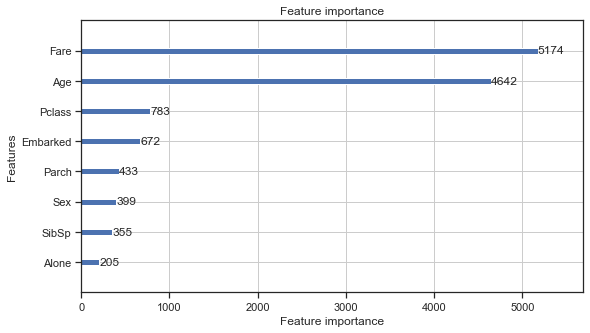

In [13]:
evaluation_results = {}

with exp.start_logging() as run:
    clf = lgbm.train(train_set=train_data,
                 params=lgbm_params,
                 valid_sets=[train_data, test_data], 
                 valid_names=['train', 'val'],
                 evals_result=evaluation_results,
                 num_boost_round=500,
                 early_stopping_rounds=100,
                 verbose_eval=20,
                 callbacks = [azure_ml_callback(run)]
                )
    
    log_metrics(clf, X_test, y_test, run)
    log_importance(clf, run)
    register_model(clf, run)
    
optimum_boost_rounds = clf.best_iteration